In [16]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray import DataArray
import pandas as pd
import pylab as plt
import scipy 
from sklearn import preprocessing
from matplotlib.ticker import NullLocator

In [17]:
# 
def rho(datax):
    # Calculates the lag-1 Autocorrelation Coefficient.
    import numpy as np  
    nrho=len(datax)
    sommesup=0
    sommeinf=0
    moy=np.sum(datax)/nrho
    datam=datax-moy
    for i in np.arange(1,nrho):
        j=i-1
        sommesup=sommesup+(datam[i]*datam[j])
        sommeinf=sommeinf+(datam[j]**2)
    rho=sommesup/sommeinf
    return rho

def rhoAlt(datax,dt=1):
    # Calculates the lag-dt Autocorrelation Coefficient, given the dt.
    import numpy as np  
    r=np.corrcoef(datax[0:-dt-1],datax[dt:-1])
    return r[0,1]

def rednoise(lenx, rho, nsim=1000, dist='normal', returnWhite=False, 
             mean=0, std=1, lo=-1, hi=1):
    '''
    Creates nsim time series of rednoise of length=lenx, with lag-1 autocorrelation rho.
    For normally-distributed series, user can provide mean and std.
    For uniformely-distributed series, user can provide low and high bounds.
    '''
    import numpy as np
    srho=(1-(rho**2))**(0.5)
    red=np.zeros((lenx,nsim))
    white=np.zeros((lenx,nsim))
    for j in range(nsim):
        for i in range(lenx):
            if dist=='normal':
                white[i,j]=np.random.normal(loc=mean, scale=std) 
            elif dist=='uniform':
                white[i,j]=np.random.uniform(low=lo, high=hi)
    for j in range(nsim):
        for i in range(lenx):
            if i==0:
                red[i,j]=white[i,j]*srho
            else:
                red[i,j]=rho*red[i-1,j]+white[i,j]*srho
    if returnWhite:
        return red, white
    else:
        return red
    
def periods(x,dt,returnPeriods=True, nsim=1000):
    import numpy as np
    from scipy import signal
    from scipy.stats.distributions import chi2
    
    # Calculate periodogram of x
    f, psd = signal.periodogram(x,fs=dt,detrend=False,scaling='spectrum')
    per=1/f
    max5=np.zeros((5,3))
    psdc=psd.copy()

    # Get the 5 larges periods
    for i in range(5):
        max5[i,0]=f[psdc==max(psdc)]
        max5[i,1]=psdc[psdc==max(psdc)]
        max5[i,2]=per[psdc==max(psdc)]
        psdc[psdc==max(psdc)]=0

    # Calculate periodograms of the nsim red-noise series
    fn=np.zeros((len(f),nsim))
    Pn=np.zeros((len(f),nsim))
    red=rednoise(len(x),rhoAlt(x,dt=dt),dist='normal',nsim=nsim)
    for i in range(nsim):
    #         if np.remainder(i,100)==0:
    #             print('%.0f %%' %(i/10))
        fn[:,i], Pn[:,i] = signal.periodogram(red[:,i],fs=dt,detrend=False,scaling='spectrum')

    # Mean spectrum of nsim simulations
    meanRed=np.mean(Pn,axis=1)

    # Get Percentiles of Distribution of Red-Noise Spectra
    pctl=np.zeros((len(f),4)) # 0.8, 0.9, 0.95, 0.99
    for i in range(len(f)):
        pctl[i,0]=np.percentile(Pn[i,:],80)
        pctl[i,1]=np.percentile(Pn[i,:],90)
        pctl[i,2]=np.percentile(Pn[i,:],95)
        pctl[i,3]=np.percentile(Pn[i,:],99)
        
    return f, psd, pctl, max5, meanRed

In [18]:
# power_spectrum for NAO C2
nao = np.load("/work/uo1075/u241321/data/eemd_NAO_DJF.npy")
nao_s = preprocessing.scale(nao[2,:])
f, psd, pctl, max5, meanred = periods(nao_s,1,returnPeriods=True, nsim=1000)

# SPG
spg = np.load("/work/uo1075/u241321/data/EEMD_spg_density.npy")   # (5,50) mode(input, c1-c4), time
spg_s = preprocessing.scale(spg[2,:])
f1, psd1, pctl1, max51, meanred1 = periods(spg_s,1,returnPeriods=True, nsim=1000)

# Norwegian T310
assi = np.load("/work/uo1075/u241321/data/eemd_t310_assi_Norwegian.npy")
assi_s = preprocessing.scale(assi[2,:])
f2, psd2, pctl2, max52, meanred2 = periods(assi_s,1,returnPeriods=True, nsim=1000)

/tmp/ipykernel_1819771/3636004146.py:58: RuntimeWarning: divide by zero encountered in divide
  per=1/f
/tmp/ipykernel_1819771/3636004146.py:58: RuntimeWarning: divide by zero encountered in divide
  per=1/f
/tmp/ipykernel_1819771/3636004146.py:58: RuntimeWarning: divide by zero encountered in divide
  per=1/f


/tmp/ipykernel_1819771/3213950144.py:5: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy(1/f, psd2,  linewidth=4, color = "black", label='T')
/tmp/ipykernel_1819771/3213950144.py:6: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy(1/f, pctl2[:,3],  linewidth=1, color = "gray", linestyle= 'dashed')
/tmp/ipykernel_1819771/3213950144.py:7: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy(1/f, meanred2,  linewidth=1, color = "gray")
/tmp/ipykernel_1819771/3213950144.py:10: RuntimeWarning: divide by zero encountered in divide
  ax1.semilogy(1/f, psd,  linewidth=4, color = "red", label='NAO')
/tmp/ipykernel_1819771/3213950144.py:11: RuntimeWarning: divide by zero encountered in divide
  ax1.semilogy(1/f, pctl[:,3],  linewidth=1, color = "gray", linestyle= 'dashed')
/tmp/ipykernel_1819771/3213950144.py:12: RuntimeWarning: divide by zero encountered in divide
  ax1.semilogy(1/f, meanred,  linewidth=1, color = "gray")
/tmp/ipykernel_1819771/

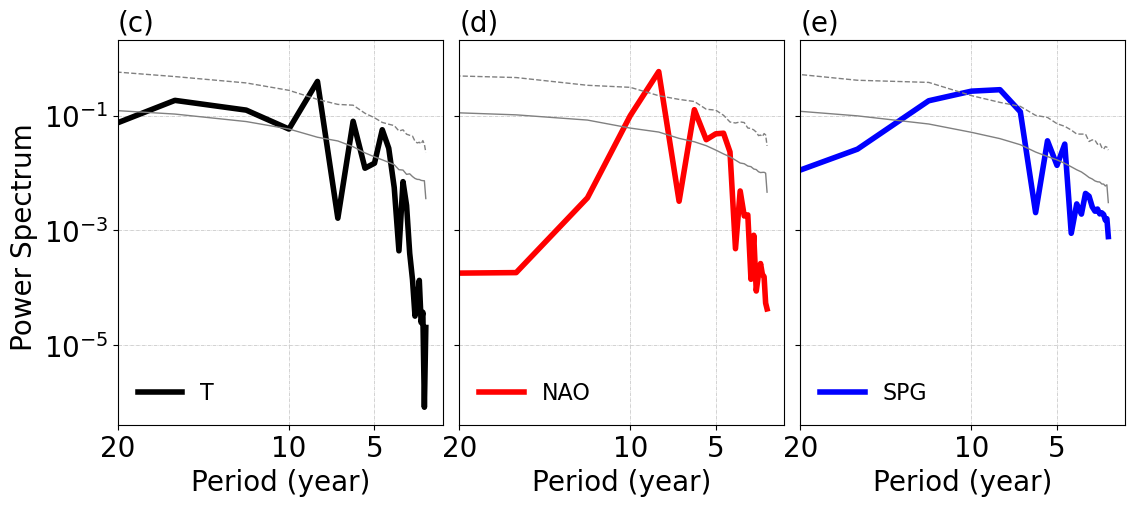

In [23]:
plt.rcParams["figure.figsize"] = (13,5)
fig, (ax, ax1, ax2) = plt.subplots(1,3, sharey=True)
plt.subplots_adjust(hspace=1,wspace =0.05)

ax.semilogy(1/f, psd2,  linewidth=4, color = "black", label='T')
ax.semilogy(1/f, pctl2[:,3],  linewidth=1, color = "gray", linestyle= 'dashed')
ax.semilogy(1/f, meanred2,  linewidth=1, color = "gray")
 

ax1.semilogy(1/f, psd,  linewidth=4, color = "red", label='NAO')
ax1.semilogy(1/f, pctl[:,3],  linewidth=1, color = "gray", linestyle= 'dashed')
ax1.semilogy(1/f, meanred,  linewidth=1, color = "gray")

ax2.semilogy(1/f, psd1,  linewidth=4, color = "blue", label='SPG')
ax2.semilogy(1/f, pctl1[:,3],  linewidth=1, color = "gray", linestyle= 'dashed')
ax2.semilogy(1/f, meanred1,  linewidth=1, color = "gray")

#ax.loglog(1/f_20, P_20,  color = "tab:red", label='NO NEST')
# ax.loglog(1/f_obs, P_obs,  color = "tab:grey", label = 'OBS')


#ax.loglog(1/f_obs, P_obs,  label='obs')
#ax.loglog(1/f, P) #,  label='F10.7')
ax.set_xlabel('Period (year)')
ax1.set_xlabel('Period (year)')
ax2.set_xlabel('Period (year)')
ax.set_ylabel('Power Spectrum ')
#ax.axvline(x=6.25, color="r")
#ax.axvline(x=11, color="r")
#ax.axvline(x=24, color="r")
ax.legend(loc='lower left', fontsize='16',frameon=False)
ax1.legend(loc='lower left', fontsize='16',frameon=False)
ax2.legend(loc='lower left', fontsize='16',frameon=False)
ax.set_xticks([20,10,5])
ax.set_xticklabels([20,10,5])
ax1.set_xticks([20,10,5])
ax1.set_xticklabels([20,10,5])

ax2.set_xticks([20,10,5])
ax2.set_xticklabels([20,10,5])

ax.yaxis.set_minor_locator(NullLocator())

ax.grid(linestyle='dashdot', linewidth=0.4)
ax1.grid(linestyle='dashdot', linewidth=0.4)
ax2.grid(linestyle='dashdot', linewidth=0.4)

ax.set_title('(c)',loc='left',fontsize=20)
ax1.set_title('(d)',loc='left',fontsize=20)
ax2.set_title('(e)',loc='left',fontsize=20)


ax.set_xlim(2e1, 1e0)
ax1.set_xlim(2e1, 1e0)
ax2.set_xlim(2e1, 1e0)
plt.rcParams["font.size"] = "20"
plt.show()
fig.savefig('/work/uo1075/u241321/results/p2.3_power.pdf',bbox_inches='tight')    

/tmp/ipykernel_1819771/2461850046.py:9: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy(1/f, psd,  linewidth=4, color = "red", label='NAO')
/tmp/ipykernel_1819771/2461850046.py:10: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy(1/f, pctl[:,3],  linewidth=1, color = "gray", linestyle= 'dashed')
/tmp/ipykernel_1819771/2461850046.py:11: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy(1/f, meanred,  linewidth=1, color = "gray")


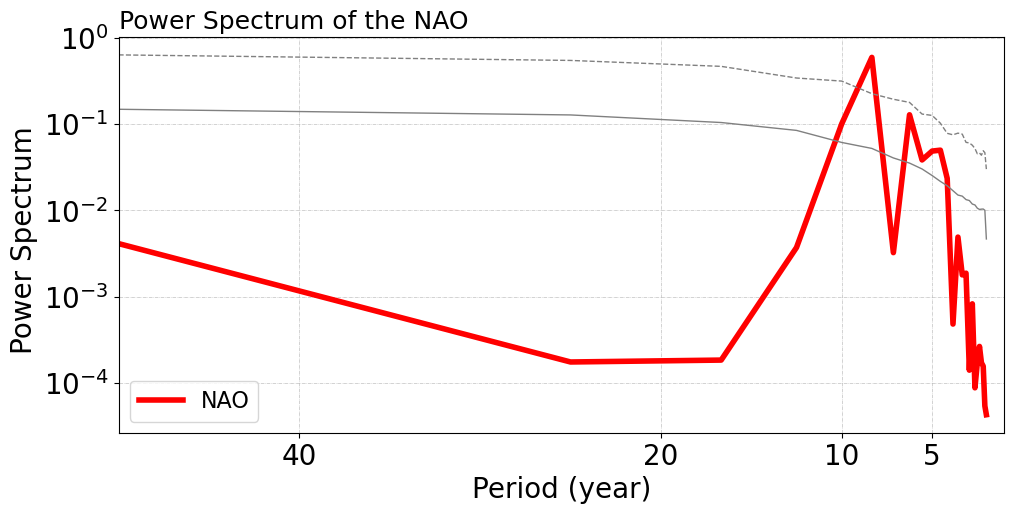

In [20]:
# # power_spectrum for NAO 
# nao = np.load("/work/uo1075/u241321/data/eemd_NAO_DJF_dt.npy")
# f, psd, pctl, max5, meanred = periods(nao[0,:],1,returnPeriods=True, nsim=1000)


plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots(figsize=(10,5))

ax.semilogy(1/f, psd,  linewidth=4, color = "red", label='NAO')
ax.semilogy(1/f, pctl[:,3],  linewidth=1, color = "gray", linestyle= 'dashed')
ax.semilogy(1/f, meanred,  linewidth=1, color = "gray")

ax.set_xlabel('Period (year)')
ax.set_ylabel('Power Spectrum ')
ax.set_xticks([40,20,10,5])
ax.set_xticklabels([40,20,10,5])
ax.legend(loc='lower left', fontsize='16')
ax.yaxis.set_minor_locator(NullLocator())
ax.grid(linestyle='dashdot', linewidth=0.4)
ax.set_title('Power Spectrum of the NAO ',loc='left',fontsize=18)

# ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlim(5e1, 1e0)

plt.tight_layout(pad=0.1, h_pad=0.1, w_pad=0.1)